# TSP solved by Simulated Annealing (SA)

In [1]:
import random as rd
import numpy as np
import pandas as pd
import math
import copy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [391]:
NUM_NODES = 15
MAX_X = 100
MAX_Y = 100

def create_data_model():
    # np.random.seed(21)
    data = {}
    data["num_locations"] = [(np.random.randint(1, MAX_X+1), np.random.randint(1, MAX_Y+1)) for i in range(NUM_NODES)]
    data["num_locations"][0] = (int(MAX_X / 2), int(MAX_Y / 2)) 
    data["distance_matrix"] = compute_manhattan_distance_matrix(data["num_locations"])
    data["depot"] = 0 # Depot 的索引值
    return data

def create_result_model():
    result = {}
    result["iteration"] = []
    result["temperature"] = []
    result["routes"] = []
    result["distance"] = []
    return result

def compute_manhattan_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                manhattan_distance = np.sum(np.abs(np.array(node_i) - np.array(node_j)))
                distances.append(manhattan_distance)
        distance_matrix.append(distances)
    return distance_matrix

def get_objective_value(route, matrix='distance_matrix'):
    objective_value = 0
    for i in range(len(route) - 1):
        objective_value += data[matrix][route[i]][route[i + 1]]
        objective_value = int(objective_value)
    return objective_value

def plot_map(routes=[]):
    plt.figure(figsize=(7, 7))
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.xlim(-5, MAX_X+5)
    plt.ylim(-5, MAX_Y+5) 
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    color_palette = [(0, 0.5, 1), (0.8, 0, 0), (0.0, 0.6, 0.2), (1, 0.7, 0.4)]
    if len(routes) > 0:
        # Draw Route for vehicle
        for i_route, route in enumerate(routes):
            # Draw lines
            RGB_colors = color_palette[i_route]
            # print('Color:', RGB_colors)
            arrow_kwargs = dict(length_includes_head=True, head_width=2, head_length=4, color=RGB_colors, alpha=0.8)
            for index, node in enumerate(route):
                start_loc = data['num_locations'][route[index]]
                end_loc = data['num_locations'][route[index + 1]] if index < (len(route) - 1) else data['num_locations'][0]
                plt.arrow(x=start_loc[0], y=start_loc[1], dx=(end_loc[0] - start_loc[0]), dy=(end_loc[1] - start_loc[1]), **arrow_kwargs)
            #  Draw nodes
            for i in route:
                text_kwargs = dict(s=str(i), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                node_kwargs = dict(s=400, color='black', alpha=0.8, edgecolors='black', marker='o')
                if i == 0: 
                    continue
                node_kwargs['color'] = RGB_colors
                node = data['num_locations'][i]
                plt.scatter(x=node[0], y=node[1], **node_kwargs)
                plt.text(x=node[0], y=node[1], **text_kwargs)
        # Draw start node
        start_node = data['num_locations'][0]
        plt.scatter(x=start_node[0], y=start_node[1], s=400, color='black', alpha=1, edgecolors='black', marker='s') 
        plt.text(x=start_node[0], y=start_node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
    else: # Print initial map
        if len(data['num_locations']) > 0:
            for index, node in enumerate(data['num_locations']):
                text_kwargs = dict(s=str(index), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                node_kwargs = dict(s=400, color='gray', alpha=0.8, edgecolors='black')
                if index == 0: 
                    plt.scatter(x=node[0], y=node[1], s=400, color='black', alpha=0.8, edgecolors='black', marker='s') 
                    plt.text(x=node[0], y=node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                    continue
                plt.scatter(x=node[0], y=node[1], **node_kwargs)
                plt.text(x=node[0], y=node[1], **text_kwargs)
        else:
            print("No data to plot.")

data = create_data_model()
pd.json_normalize(data)

,num_locations,distance_matrix,depot
0,"[(50, 50), (32, 30), (27, 12), (30, 70), (60, ...","[[0, 38, 61, 40, 53, 64, 28, 11, 73, 58, 75, 5...",0


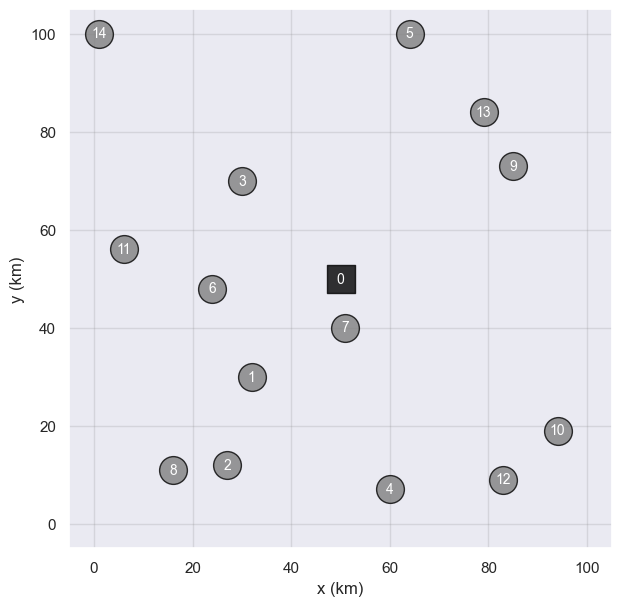

In [392]:
plot_map()

In [393]:
# 利用 Greedy 解 Initial Solution 
def solve_TSP_by_greedy_algorithm(start_index):
    route = [start_index]
    distances = copy.deepcopy(data["distance_matrix"])

    def do_greedy_iteration(node_index):
        if len(route) == (len(distances) - 1):
            route.append(0)
            return
        else:
            distances[node_index][0] = 999999
            distances[node_index][node_index] = 999999
            next_index = distances[node_index].index(min(distances[node_index]))
            route.append(next_index)
            for i in range(len(distances)):
                distances[i][node_index] = 999999
            return do_greedy_iteration(next_index)

    do_greedy_iteration(start_index)
    return route

initial_solution = solve_TSP_by_greedy_algorithm(0)
initial_dist = get_objective_value(initial_solution)

# result["iteration"].append(0)
# result["routes"].append(initial_solution)
# result["distance"].append(initial_dist)

print('Greedy Solution \n---------------')
print('Initial Route:', initial_solution)
print('Initial Distance:', initial_dist)

Greedy Solution 
---------------
Initial Route: [0, 7, 1, 2, 8, 6, 11, 3, 9, 13, 5, 14, 4, 12, 0]
Initial Distance: 604


In [418]:
'''
[Simulated Annealing 參數]
max_iter: maximum iteration
s_0: initial solution
t_0: initial temperature
t_min: end temerpature

alpha: Reduce factor
'''

max_iter = 500
initial_temp = 10000
t_min = 40
alpha = 0.99

max_m = 40 # 特定溫度下的迭代次數, 部分文獻有討論到內循環(Metropolis)

def get_random_solution():
    nodes = [i for i in range(1,NUM_NODES)]
    rd.shuffle(nodes)
    return [0] + nodes + [0]

def swap_node(route):
    n1 = rd.choice(range(1, len(route)-1))
    n2 = rd.choice(range(1, len(route)-1))
    route[n1], route[n2] = route[n2], route[n1]
    return route    

def solve_TSP_by_simulated_annealing():
    iter = 0
    t_0 = initial_temp
    # s_0 = initial_solution
    s_0 = get_random_solution()
    dist_0 = get_objective_value(s_0)
    result["iteration"].append(iter)
    result["temperature"].append(t_0)
    result["routes"].append(s_0)
    result["distance"].append(dist_0)
    # 外循環, 滿足迭代上限或達到冷卻溫度後結束
    while iter < max_iter and t_0 > t_min:
        iter += 1
        times = 0
        # 內循環, 在固定的 max_inner 次數內透過 Monte Carlo 求解
        while times < max_m:
            times += 1
            # generate candidate solution
            new_route = swap_node(s_0)
            # solution 不能與之前迭代重複
            if new_route in result["routes"]:
                new_route = swap_node(s_0)
            # compute delta
            new_dist = get_objective_value(new_route)
            delta = new_dist - dist_0
            if delta < 0:
                # accept new route
                s_0, dist_0 = new_route, new_dist
            else:
                # accept with probability exp(-diff/T)
                prob = math.exp(-delta/t_0)
                r = rd.uniform(0,1)
                if r <= prob:
                    s_0, dist_0 = new_route, new_dist
        # decrease temperature
        t_0 = int(t_0 * alpha)
        # print('T:', t_0, ', Dist:', dist_0)
        result["iteration"].append(iter)
        result["temperature"].append(t_0)
        result["routes"].append(s_0)
        result["distance"].append(dist_0)
    # print('Best Route:', s_0, ', Distance:', dist_0)

In [419]:
result = create_result_model()
solve_TSP_by_simulated_annealing()
df_result = pd.DataFrame(result)
df_result

,iteration,temperature,routes,distance
0,0,10000,"[0, 6, 13, 4, 11, 14, 9, 2, 8, 7, 5, 1, 3, 12,...",1002
1,1,9900,"[0, 6, 13, 4, 11, 14, 9, 2, 8, 7, 5, 1, 3, 12,...",1234
2,2,9801,"[0, 6, 13, 4, 11, 14, 9, 2, 8, 7, 5, 1, 3, 12,...",954
3,3,9702,"[0, 6, 13, 4, 11, 14, 9, 2, 8, 7, 5, 1, 3, 12,...",1290
4,4,9604,"[0, 6, 13, 4, 11, 14, 9, 2, 8, 7, 5, 1, 3, 12,...",1046
...,...,...,...,...
473,473,44,"[0, 6, 13, 4, 11, 14, 9, 2, 8, 7, 5, 1, 3, 12,...",938
474,474,43,"[0, 6, 13, 4, 11, 14, 9, 2, 8, 7, 5, 1, 3, 12,...",1114
475,475,42,"[0, 6, 13, 4, 11, 14, 9, 2, 8, 7, 5, 1, 3, 12,...",904
476,476,41,"[0, 6, 13, 4, 11, 14, 9, 2, 8, 7, 5, 1, 3, 12,...",936


<AxesSubplot: xlabel='iteration', ylabel='temperature'>

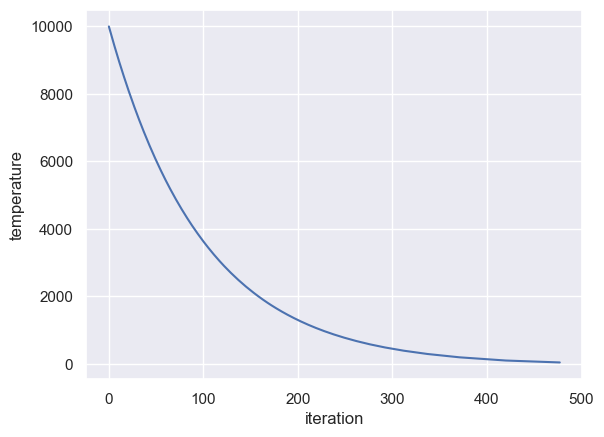

In [420]:
sns.lineplot(data=df_result, x="iteration", y="temperature")

<AxesSubplot: title={'center': 'Solved TSP by Simulated Annealing (SA)'}, xlabel='iteration', ylabel='distance'>

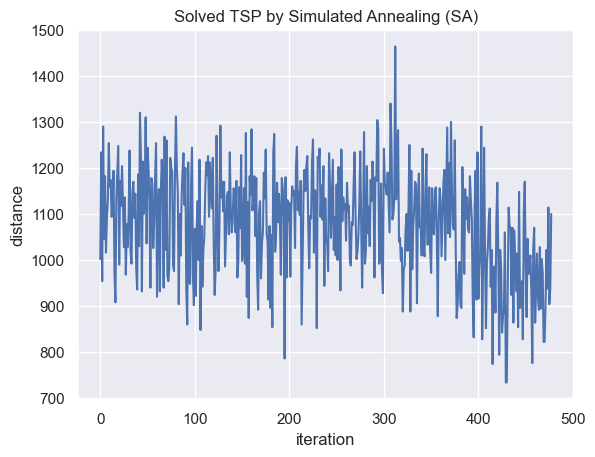

In [421]:
plt.title('Solved TSP by Simulated Annealing (SA)')
sns.lineplot(data=df_result, x="iteration", y="distance")

Best Route: [0, 6, 13, 4, 11, 14, 9, 2, 8, 7, 5, 1, 3, 12, 10, 0]
Distance: 734


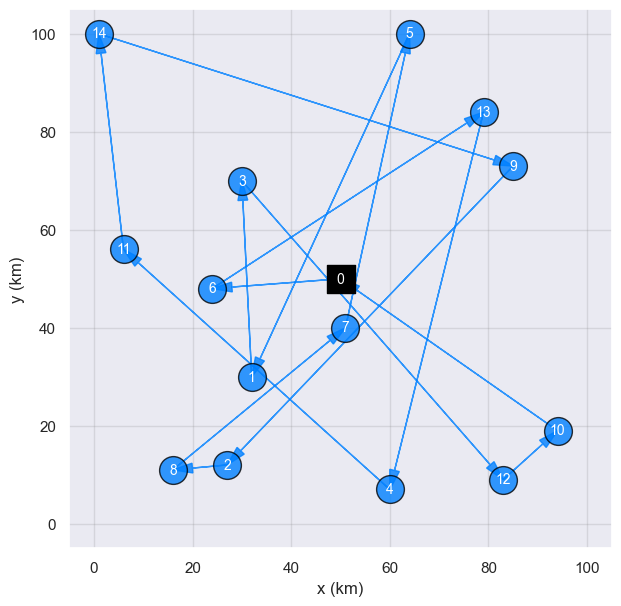

In [422]:
best_s = df_result[df_result["distance"] == df_result["distance"].min()]
print('Best Route:', best_s["routes"].values[0])
print('Distance:', best_s["distance"].values[0])

plot_map(routes=[best_s["routes"].values[0]])

會需要執行多次退火演算法，從裡面中找到最佳解